# Inferring IPv6 Activity Using Hyper-Specific Prefixes

## 1. Setup

### Imports

In [1]:
import pytricia
from ipaddress import ip_network
import matplotlib.pyplot as plt
from tqdm import tqdm

### Read datasets

In [2]:
with open("parsed_data/rrc01.20220801.1600_parse.txt") as infile:  # RRC01 route data
    routes = [tuple(route.rstrip().split()) for route in infile if route.rstrip()]

with open("parsed_data/arin") as infile:  # ARIN WHOIS
    arin_whois = [ip.rstrip() for ip in infile if ip.rstrip()]

with open("parsed_data/afrinic") as infile:  # AFRINIC WHOIS
    afrinic_whois = [ip.rstrip() for ip in infile if ip.rstrip()]

with open("parsed_data/apnic") as infile:  # APNIC WHOIS
    apnic_whois = [ip.rstrip() for ip in infile if ip.rstrip()]

with open("parsed_data/ripe") as infile:  # RIPE WHOIS
    ripe_whois = [ip.rstrip() for ip in infile if ip.rstrip()]

with open("parsed_data/responsive-addresses.txt") as infile:  # IPv6 hitlist
    responsive_ips = [ip.rstrip() for ip in infile if ip.rstrip()]

## 2. Routing Inferences

### Build LPM prefix tree from RRC route data

In [40]:
prefix_dict = {}
rrc_pyt = pytricia.PyTricia(128)
routes_ipv6 = [route for route in routes if ip_network(route[0]).version == 6]
hsps = {}
# iterate over ipv6 routes and build pytricia tree for non-hsp routes
for prefix in routes_ipv6:
    asns = prefix[1].split("/")
    asn_set = set()
    for asn in asns:
        if "{" not in asn:
            asn_set.add(int(asn))
        else:
            asn = asn.strip("{}").split(",")
            asn = set([int(a) for a in asn])
            asn_set.union(asn)
    prefix_dict[ip_network(prefix[0])] = asn_set
    if ip_network(prefix[0]).prefixlen <= 48:  # > /48 is HSP
        rrc_pyt[prefix[0]] = asn_set  # larger routes go to tree
    else:
        hsps[prefix[0]] = asn_set  # hsp routes go to dict

### Compute longest prefix match for HSPs using route data

In [41]:
# iterate over hsp routes and check if they are contained in the tree
lpm = {}  # store the longest prefix match for an hsp
for hsp in hsps.keys():
    if hsp in rrc_pyt:
        lpm[ip_network(hsp)] = ip_network(rrc_pyt.get_key(hsp))
    else:
        raise ValueError("HSP not found in tree.")

### Statistics of Routing Data

#### CDF Plots for HSP, LPM Prefix lengths

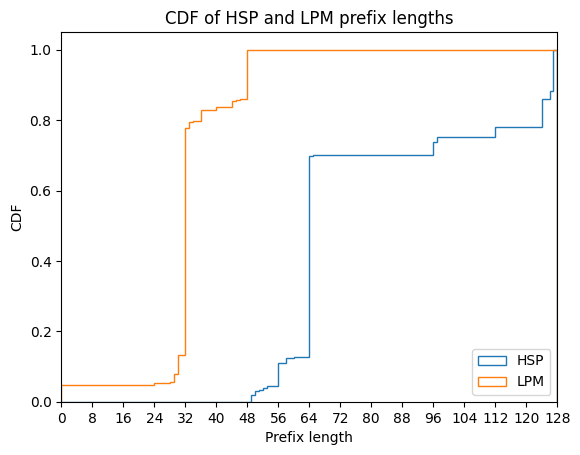

In [5]:
# Plot CDFs of HSP and LPM prefix lengths
hsp_prefixlen = [hsp.prefixlen for hsp in lpm.keys()]
lpm_prefixlen = [lpm[hsp].prefixlen for hsp in lpm.keys()]
prefix_range = range(0, 129)
plt.hist(
    hsp_prefixlen,
    bins=prefix_range,
    density=True,
    cumulative=True,
    histtype="step",
    label="HSP",
)
plt.hist(
    lpm_prefixlen,
    bins=prefix_range,
    density=True,
    cumulative=True,
    histtype="step",
    label="LPM",
)
plt.legend(loc="lower right")
plt.xlabel("Prefix length")
plt.xlim([0, 128])
plt.xticks(range(0, 129, 8))
plt.ylabel("CDF")
plt.title("CDF of HSP and LPM prefix lengths")
plt.show()

#### Number of distinct prefix lengths in HSPs

Number of distinct prefix lengths of HSPs - 24


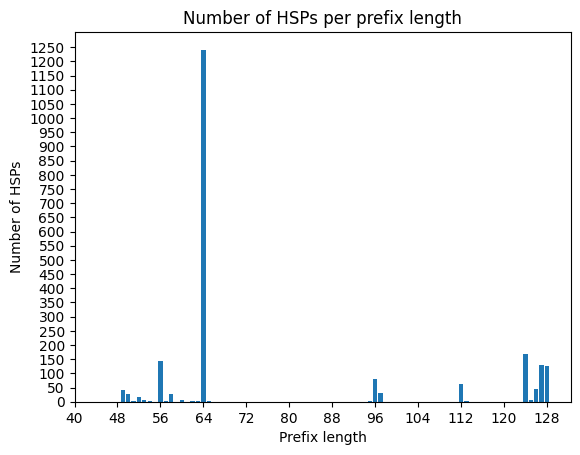

Top 5 HSPs prefix length counts:
1. /64 - 1241
2. /124 - 167
3. /56 - 144
4. /127 - 131
5. /128 - 125


In [6]:
# number of distinct prefix lengths of HSPs
hsp_prefixlen_distinct = set(hsp_prefixlen)
print(f"Number of distinct prefix lengths of HSPs - {len(hsp_prefixlen_distinct)}")
hsp_prefixlen_counts = {}
for prefixlen in hsp_prefixlen_distinct:
    hsp_prefixlen_counts[prefixlen] = hsp_prefixlen.count(prefixlen)

# plot a bar chart of the number of HSPs per prefix length
plt.bar(hsp_prefixlen_counts.keys(), hsp_prefixlen_counts.values())
plt.xlabel("Prefix length")
plt.xticks(range(40, 129, 8))
plt.ylabel("Number of HSPs")
plt.yticks(range(0, 1300, 50))
plt.title("Number of HSPs per prefix length")
plt.show()

# top 5 HSPs by prefix length counts
hsp_prefixlen_counts_sorted = sorted(
    hsp_prefixlen_counts.items(), key=lambda x: x[1], reverse=True
)
print("Top 5 HSPs prefix length counts:")
for i in range(5):
    print(
        f"{i+1}. /{hsp_prefixlen_counts_sorted[i][0]} - {hsp_prefixlen_counts_sorted[i][1]}"
    )

#### CDF plots for LPM prefix lengths for top HSPs by prefix length

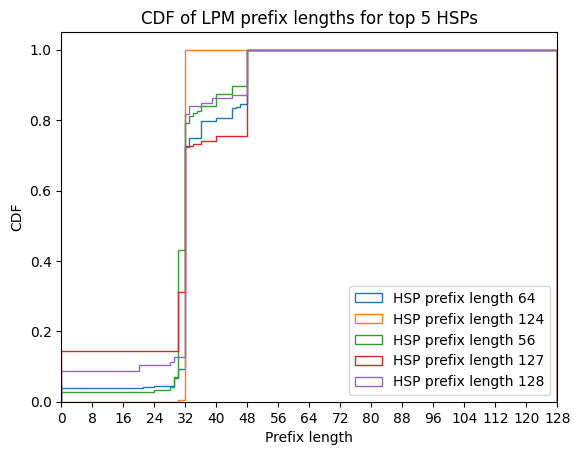

In [56]:
# for each of the top 5 HSPs, plot the CDF of LPMs per prefix length
for i in range(5):
    prefixlen = hsp_prefixlen_counts_sorted[i][0]
    lpm_prefixlen = [
        lpm[hsp].prefixlen for hsp in lpm.keys() if hsp.prefixlen == prefixlen
    ]
    plt.hist(
        lpm_prefixlen,
        bins=prefix_range,
        density=True,
        cumulative=True,
        histtype="step",
        label=f"HSP prefix length {prefixlen}",
    )
plt.legend(loc="lower right")
plt.xlabel("Prefix length")
plt.xlim([0, 128])
plt.xticks(range(0, 129, 8))
plt.ylabel("CDF")
plt.title("CDF of LPM prefix lengths for top 5 HSPs")
plt.show()

#### Probability of LPM prefix length for top 5 HSPs

In [57]:
# get probability of LPM prefix length for top 5 HSPs
for i in range(5):
    hsp_prefixlen = hsp_prefixlen_counts_sorted[i][0]
    lpm_prefixlen = [
        lpm[hsp].prefixlen for hsp in lpm.keys() if hsp.prefixlen == hsp_prefixlen
    ]
    lpm_prefixlen_distinct = set(lpm_prefixlen)
    lpm_prefixlen_counts = {}
    for prefixlen in lpm_prefixlen_distinct:
        lpm_prefixlen_counts[prefixlen] = lpm_prefixlen.count(prefixlen)
    lpm_prefixlen_counts_sorted = sorted(
        lpm_prefixlen_counts.items(), key=lambda x: x[1], reverse=True
    )
    print(f"Probabilities of top 5 LPMs for HSP /{hsp_prefixlen}:")
    for j in range(5):
        if j >= len(lpm_prefixlen_counts_sorted):
            break
        print(
            f"{j+1}. /{lpm_prefixlen_counts_sorted[j][0]} - {round(lpm_prefixlen_counts_sorted[j][1]/len(lpm_prefixlen), 4)}"
        )

Probabilities of top 5 LPMs for HSP /64:
1. /32 - 0.6317
2. /48 - 0.1555
3. /36 - 0.0475
4. /0 - 0.0395
5. /44 - 0.0266
Probabilities of top 5 LPMs for HSP /124:
1. /32 - 0.994
2. /30 - 0.006
Probabilities of top 5 LPMs for HSP /56:
1. /32 - 0.3611
2. /30 - 0.3611
3. /48 - 0.1042
4. /40 - 0.0347
5. /0 - 0.0278
Probabilities of top 5 LPMs for HSP /127:
1. /32 - 0.4122
2. /48 - 0.2443
3. /30 - 0.1679
4. /0 - 0.145
5. /40 - 0.0153
Probabilities of top 5 LPMs for HSP /128:
1. /32 - 0.688
2. /48 - 0.128
3. /0 - 0.088
4. /33 - 0.024
5. /39 - 0.016


### Top 10 ASNs having HSPs

In [19]:
# get the top 10 ASNs with the most number of HSPs
asns = {}
for hsp in hsps:
    asns[str(hsp)] = hsps[hsp]
asns_counts = {}
for asn in asns:
    for _asn in asns[asn]:
        if type(_asn) == "int":
            raise ValueError(f"ASN is not an integer., {_asn} - {type(_asn)}")
        if _asn in asns_counts:
            asns_counts[_asn] += 1
        else:
            asns_counts[_asn] = 1
asns_counts_sorted = sorted(asns_counts.items(), key=lambda x: x[1], reverse=True)
print("Top 10 ASNs with the most number of HSPs:")
for i in range(10):
    print(f"{i+1}. {asns_counts_sorted[i][0]} - {asns_counts_sorted[i][1]}")

Top 10 ASNs with the most number of HSPs:
1. 7713 - 552
2. 28885 - 143
3. 8151 - 112
4. 262191 - 83
5. 52468 - 82
6. 9583 - 66
7. 4657 - 62
8. 6866 - 55
9. 4761 - 54
10. 13536 - 48


#### ASN 7713

In [25]:
# get HSPs for ASN 7713
asn_7713_hsp = [prefix for prefix in asns if 7713 in asns[prefix]]
with open("results/7713_hsps.txt", "w") as f:
    for prefix in asn_7713_hsp:
        f.write(f"{prefix}\n")

### Top HSP & LPM prefix lengths per ASN

In [45]:
# top HSP & LPM prefix lengths per ASN
from collections import Counter

print("Top HSP & LPM prefix lengths for ASNs with most HSPs:")
asn_prefixlen_counts = {}
asn_hsp_counts = {}
for idx, asn in enumerate(asns_counts_sorted):
    if idx == 10:
        break
    for hsp in hsps:
        if asn[0] in rrc_pyt[str(lpm[ip_network(hsp)])]:
            if asn[0] not in asn_prefixlen_counts:
                asn_prefixlen_counts[asn[0]] = []
            asn_prefixlen_counts[asn[0]].append(lpm[ip_network(hsp)].prefixlen)
        if asn[0] in hsps[str(hsp)]:
            if asn[0] not in asn_hsp_counts:
                asn_hsp_counts[asn[0]] = []
            asn_hsp_counts[asn[0]].append(ip_network(hsp).prefixlen)

    prefixlen_counter = Counter(asn_prefixlen_counts[asn[0]])
    max_prefixlen = prefixlen_counter.most_common(1)[0][0]
    hsp_counter = Counter(asn_hsp_counts[asn[0]])
    max_hsp = hsp_counter.most_common(1)[0][0]
    print(
        f"ASN {asn[0]}: Top HSP prefix length /{max_hsp}, Top LPM prefix length /{max_prefixlen}"
    )

Top HSP & LPM prefix lengths for ASNs with most HSPs:
ASN 7713: Top HSP prefix length /124, Top LPM prefix length /32
ASN 28885: Top HSP prefix length /64, Top LPM prefix length /32
ASN 8151: Top HSP prefix length /64, Top LPM prefix length /32
ASN 262191: Top HSP prefix length /127, Top LPM prefix length /48
ASN 52468: Top HSP prefix length /64, Top LPM prefix length /32
ASN 9583: Top HSP prefix length /64, Top LPM prefix length /32
ASN 4657: Top HSP prefix length /64, Top LPM prefix length /30
ASN 6866: Top HSP prefix length /56, Top LPM prefix length /30
ASN 4761: Top HSP prefix length /64, Top LPM prefix length /32
ASN 13536: Top HSP prefix length /64, Top LPM prefix length /32


## 3. WHOIS Inferences

### Build prefix tree from WHOIS data

In [34]:
whois_records = arin_whois + afrinic_whois + apnic_whois + ripe_whois
whois_pyt = pytricia.PyTricia(128)
# iterate over whois records and try to match them with the hsp prefixes
for idx, whois in enumerate(whois_records):
    whois_pyt[whois] = idx

### Compute longest prefix match for HSPs using WHOIS data

In [35]:
whois_assignment = {}  # store the whois record for each hsp
for hsp in hsps.keys():
    if hsp in whois_pyt:
        whois_assignment[ip_network(hsp)] = ip_network(whois_pyt.get_key(hsp))
    else:
        raise ValueError("HSP not found in tree.")

### Statistics of WHOIS records

#### Max, Mean, Media Prefix Lengths of WHOIS Records

In [9]:
# get max prefix length of all whois records
whois_records_ip = [ip_network(whois).prefixlen for whois in whois_records]
max_prefixlen = max(whois_records_ip)
print(f"Max prefix length of WHOIS records - {max_prefixlen}")
avg_prefixlen = sum(whois_records_ip) / len(whois_records_ip)
print(f"Average prefix length of WHOIS records - {avg_prefixlen}")
median_prefixlen = sorted(whois_records_ip)[len(whois_records_ip) // 2]
print(f"Median prefix length of WHOIS records - {median_prefixlen}")

Max prefix length of WHOIS records - 128
Average prefix length of WHOIS records - 55.281233018403185
Median prefix length of WHOIS records - 56


#### Number of ::/0 WHOIS records

In [19]:
# number of HSPs that have no corresponding whois record
null_whois_counter = 0
for hsp in whois_assignment:
    if str(whois_assignment[hsp]) == "::/0":
        null_whois_counter += 1
        print(f"HSP {hsp} has WHOIS record = {whois_assignment[hsp]}")

print(f"Number of HSPs with no corresponding WHOIS record - {null_whois_counter}")
print(
    f"Probability of HSPs where WHOIS record is equal to HSP - {round(null_whois_counter / len(whois_assignment), 4)}"
)

HSP ::/96 has WHOIS record = ::/0
HSP 1:1900:5:2:2::2a0c/126 has WHOIS record = ::/0
HSP 1900:2100::2a2c/126 has WHOIS record = ::/0
HSP 2100:1900:5:2:2::1ba4/126 has WHOIS record = ::/0
Number of HSPs with no corresponding WHOIS record - 4
Probability of HSPs where WHOIS record is equal to HSP - 0.0018


#### Number of HSP = WHOIS assignment records 

In [20]:
# number of HSPs where the WHOIS record is the same as the HSP
same_whois_counter = 0
for hsp in whois_assignment:
    if str(whois_assignment[hsp]) == str(hsp):
        same_whois_counter += 1

print(f"Number of HSPs where WHOIS record is equal to HSP - {same_whois_counter}")
print(
    f"Probability of HSPs where WHOIS record is equal to HSP - {round(same_whois_counter / len(whois_assignment), 4)}"
)

Number of HSPs where WHOIS record is equal to HSP - 27
Probability of HSPs where WHOIS record is equal to HSP - 0.0124


#### CDF of difference between HSP and corresponding WHOIS record

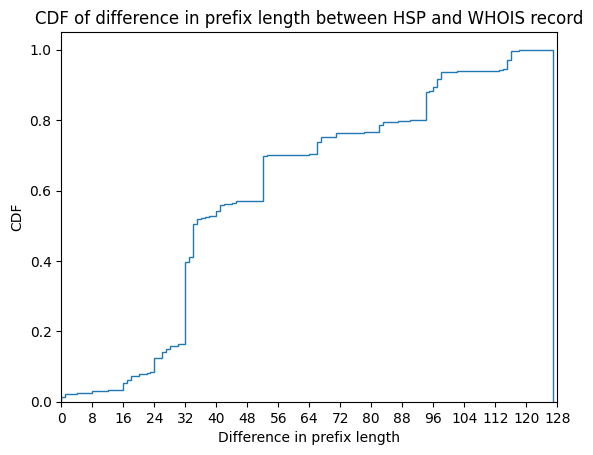

In [14]:
# plot CDF of difference between HSP and corresponding WHOIS record prefix lengths
diff_prefixlen = [
    hsp.prefixlen - whois_assignment[hsp].prefixlen for hsp in whois_assignment
]
plt.hist(
    diff_prefixlen,
    bins=range(0, 128),
    density=True,
    cumulative=True,
    histtype="step",
)
plt.xlabel("Difference in prefix length")
plt.xlim([0, 128])
plt.xticks(range(0, 129, 8))
plt.ylabel("CDF")
plt.title("CDF of difference in prefix length between HSP and WHOIS record")
plt.show()

#### CDF of WHOIS prefix lengths for top 5 HSPs by prefix length

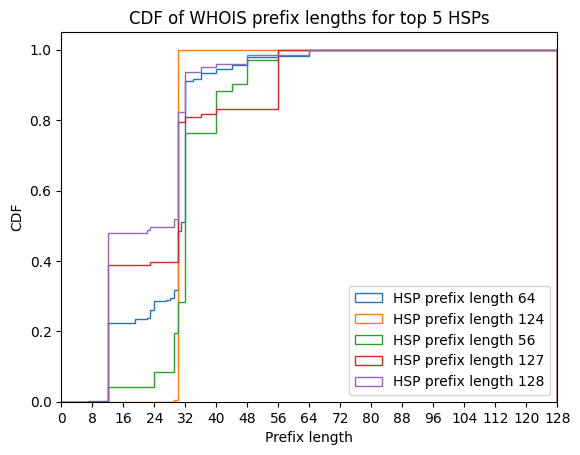

In [10]:
# for each of the top 5 HSPs, plot the CDF of WHOIS sizes by prefix length
for i in range(5):
    prefixlen = hsp_prefixlen_counts_sorted[i][0]
    whois_prefixlen = [
        whois_assignment[hsp].prefixlen
        for hsp in whois_assignment.keys()
        if hsp.prefixlen == prefixlen
    ]
    plt.hist(
        whois_prefixlen,
        bins=prefix_range,
        density=True,
        cumulative=True,
        histtype="step",
        label=f"HSP prefix length {prefixlen}",
    )
plt.legend(loc="lower right")
plt.xlabel("Prefix length")
plt.xlim([0, 128])
plt.xticks(range(0, 129, 8))
plt.ylabel("CDF")
plt.title("CDF of WHOIS prefix lengths for top 5 HSPs")
plt.show()

### Find the geographic region for each HSP

In [11]:
# Assigning a location to each HSP
rir_map = {
    "arin": "North America",
    "afrinic": "Africa",
    "apnic": "Asia Pacific",
    "ripe": "Europe & Middle East",
    "err": "Error",
}
hsp_location = {}
hsp_location_error = 0
arin_count, afrinic_count, apnic_count, ripe_count = 0, 0, 0, 0
for hsp, whois in whois_assignment.items():
    if str(whois) in arin_whois:
        arin_count += 1
        hsp_location[hsp] = rir_map["arin"]
    elif str(whois) in afrinic_whois:
        afrinic_count += 1
        hsp_location[hsp] = rir_map["afrinic"]
    elif str(whois) in apnic_whois:
        apnic_count += 1
        hsp_location[hsp] = rir_map["apnic"]
    elif str(whois) in ripe_whois:
        ripe_count += 1
        hsp_location[hsp] = rir_map["ripe"]
    else:
        hsp_location_error += 1
        hsp_location[hsp] = rir_map["err"]

print(f"Number of HSPs with unknown location - {hsp_location_error}")
print(f"Number of HSPs in ARIN - {arin_count}")
print(f"Number of HSPs in AFRINIC - {afrinic_count}")
print(f"Number of HSPs in APNIC - {apnic_count}")
print(f"Number of HSPs in RIPE - {ripe_count}")

Number of HSPs with unknown location - 1
Number of HSPs in ARIN - 783
Number of HSPs in AFRINIC - 41
Number of HSPs in APNIC - 932
Number of HSPs in RIPE - 416


## 4. IP Hitlist Inferences

### Active IP addresses for each HSP's LPM Route

In [12]:
# reverse the lpm dict
lpm_reverse = {}
for hsp, lpm in lpm.items():
    if lpm in lpm_reverse:
        lpm_reverse[lpm].append(hsp)
    else:
        lpm_reverse[lpm] = [hsp]

# build a tree with just the lpm prefixes
lpm_pyt = pytricia.PyTricia(128)
for idx, lpm in enumerate(lpm_reverse):
    lpm_pyt[lpm] = idx

# iterate over the responsive addresses and try to match them with the lpm prefixes
active_ips = {}
for ip in responsive_ips:
    if ip in lpm_pyt:
        lpm = lpm_pyt.get_key(ip)
        if lpm == "::/0":
            continue
        if lpm not in active_ips:
            active_ips[lpm] = []
        active_ips[lpm].append(ip)
    else:
        raise ValueError("IP not found in tree.")

#### Statistics of active IP addresses in LPM routes

In [14]:
# max number of responsive IPs per HSP LPM
responsive_ips_per_lpm = [len(active_ips[lpm]) for lpm in active_ips]
max_responsive_ips = max(responsive_ips_per_lpm)
min_responsive_ips = min(responsive_ips_per_lpm)
avg_responsive_ips = sum(responsive_ips_per_lpm) / len(responsive_ips_per_lpm)
median_responsive_ips = sorted(responsive_ips_per_lpm)[len(responsive_ips_per_lpm) // 2]
total_responsive_ips = len(responsive_ips)

print(f"Max number of responsive IPs per HSP LPM - {max_responsive_ips}")
print(f"Min number of responsive IPs per HSP LPM - {min_responsive_ips}")
print(f"Average number of responsive IPs per HSP LPM - {avg_responsive_ips}")
print(f"Median number of responsive IPs per HSP LPM - {median_responsive_ips}")
print(f"Total number of responsive IPs - {total_responsive_ips}")

Max number of responsive IPs per HSP LPM - 109115
Min number of responsive IPs per HSP LPM - 1
Average number of responsive IPs per HSP LPM - 1693.6938775510205
Median number of responsive IPs per HSP LPM - 33
Total number of responsive IPs - 6826560


#### CDF of active IPs in HSP LPM Routes

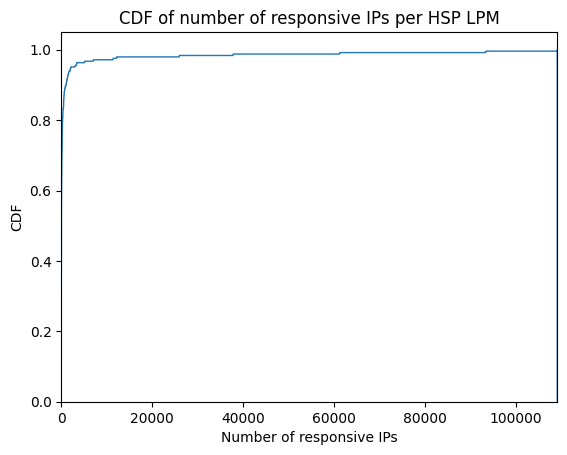

In [15]:
# plot CDF of number of responsive IPs per HSP LPM
plt.hist(
    responsive_ips_per_lpm,
    bins=range(0, max(responsive_ips_per_lpm) + 1),
    density=True,
    cumulative=True,
    histtype="step",
)
plt.xlabel("Number of responsive IPs")
plt.xlim([0, max(responsive_ips_per_lpm)])
plt.ylabel("CDF")
plt.title("CDF of number of responsive IPs per HSP LPM")
plt.show()

#### Top & bottom 10 HSP LPM by number of active IPs

In [18]:
# top 10 HSP LPMs with most responsive IPs
top_10_lpm = sorted(active_ips, key=lambda x: len(active_ips[x]), reverse=True)[:10]
print("Top 10 HSP LPMs with most responsive IPs")
for lpm in top_10_lpm:
    print(
        f"LPM: {lpm}, Number of responsive IPs - {len(active_ips[lpm])}, ASN - {', '.join(list(map(str,rrc_pyt[lpm])))}"
    )

# Bottom 10 HSP LPMs with most responsive IPs
bottom_10_lpm = sorted(active_ips, key=lambda x: len(active_ips[x]))[:10]
print("Bottom 10 HSP LPMs with most responsive IPs")
for lpm in bottom_10_lpm:
    print(
        f"LPM: {lpm}, Number of responsive IPs - {len(active_ips[lpm])}, ASN - {', '.join(list(map(str,rrc_pyt[lpm])))}"
    )

Top 10 HSP LPMs with most responsive IPs
LPM: 2001:558::/29, Number of responsive IPs - 109115, ASN - 7922
LPM: 2600:1400::/24, Number of responsive IPs - 93373, ASN - 20940
LPM: 2a02:26f0::/32, Number of responsive IPs - 61229, ASN - 20940, 34164
LPM: 2001:470::/32, Number of responsive IPs - 37804, ASN - 6939
LPM: 2001:1900::/32, Number of responsive IPs - 25957, ASN - 3356
LPM: 2620:0:1c00::/40, Number of responsive IPs - 12170, ASN - 32934
LPM: 2406:3000::/30, Number of responsive IPs - 11384, ASN - 4657
LPM: 2001:668::/32, Number of responsive IPs - 7032, ASN - 3257
LPM: 2001:438::/32, Number of responsive IPs - 5110, ASN - 6461
LPM: 2001:418::/32, Number of responsive IPs - 3387, ASN - 2914
Bottom 10 HSP LPMs with most responsive IPs
LPM: 2001:42d8:1113::/48, Number of responsive IPs - 1, ASN - 29571
LPM: 2001:508::/32, Number of responsive IPs - 1, ASN - 32020
LPM: 2001:67c:189c::/48, Number of responsive IPs - 1, ASN - 1257
LPM: 2001:6d0:6d0::/48, Number of responsive IPs - 1, 

### Active IP address for each HSP WHOIS record

In [36]:
# reverse the whois dict
whois_assignment_reverse = {}
for hsp, whois_lpm in whois_assignment.items():
    if whois_lpm in whois_assignment_reverse:
        whois_assignment_reverse[whois_lpm].append(hsp)
    else:
        whois_assignment_reverse[whois_lpm] = [hsp]

# build a tree with just the whois prefixes
whois_ip_pyt = pytricia.PyTricia(128)
for idx, whois_lpm in enumerate(whois_assignment_reverse):
    whois_ip_pyt[whois_lpm] = idx

# iterate over the responsive addresses and try to match them with the whois lpm prefixes
active_ips = {}
for ip in responsive_ips:
    if ip in whois_ip_pyt:
        whois_lpm = whois_ip_pyt.get_key(ip)
        if whois_lpm == "::/0":
            continue
        if whois_lpm not in active_ips:
            active_ips[whois_lpm] = []
        active_ips[whois_lpm].append(ip)
    else:
        raise ValueError("IP not found in tree.")

#### Statistics of active IP addresses in WHOIS records

In [46]:
# max number of responsive IPs per HSP WHOIS record
responsive_ips_per_whois = [len(active_ips[lpm]) for lpm in active_ips]
max_responsive_ips = max(responsive_ips_per_whois)
min_responsive_ips = min(responsive_ips_per_whois)
avg_responsive_ips = sum(responsive_ips_per_whois) / len(responsive_ips_per_whois)
median_responsive_ips = sorted(responsive_ips_per_whois)[
    len(responsive_ips_per_whois) // 2
]
total_responsive_ips = len(responsive_ips)

print(f"Max number of responsive IPs per HSP WHOIS - {max_responsive_ips}")
print(f"Min number of responsive IPs per HSP WHOIS - {min_responsive_ips}")
print(f"Average number of responsive IPs per HSP WHOIS - {avg_responsive_ips}")
print(f"Median number of responsive IPs per HSP WHOIS - {median_responsive_ips}")
print(f"Total number of responsive IPs - {total_responsive_ips}")

Max number of responsive IPs per HSP WHOIS - 150585
Min number of responsive IPs per HSP WHOIS - 1
Average number of responsive IPs per HSP WHOIS - 3602.9030303030304
Median number of responsive IPs per HSP WHOIS - 67
Total number of responsive IPs - 6826560


#### Top & bottom 10 HSP WHOIS records by number of active IPs

In [39]:
# top 10 HSP WHOIS records with most responsive IPs
top_10_whois = sorted(active_ips, key=lambda x: len(active_ips[x]), reverse=True)[:10]
print("Top 10 HSP WHOIS records with most responsive IPs")
for whois in top_10_whois:
    print(
        f"WHOIS: {whois}, Number of responsive IPs - {len(active_ips[whois])}, ASN - {', '.join(list(map(str,rrc_pyt[whois])))}"
    )

# Bottom 10 HSP WHOIS records with most responsive IPs
bottom_10_whois = sorted(active_ips, key=lambda x: len(active_ips[x]))[:10]
print("Bottom 10 HSP WHOIS records with most responsive IPs")
for whois in bottom_10_whois:
    print(
        f"WHOIS: {whois}, Number of responsive IPs - {len(active_ips[whois])}, ASN - {', '.join(list(map(str,rrc_pyt[whois])))}"
    )

Top 10 HSP WHOIS records with most responsive IPs
WHOIS: 2800::/12, Number of responsive IPs - 150585, ASN - 207841, 1299, 174, 25369
WHOIS: 2001:558::/29, Number of responsive IPs - 109115, ASN - 7922
WHOIS: 2600:1400::/24, Number of responsive IPs - 95010, ASN - 20940
WHOIS: 2a02:26f0::/29, Number of responsive IPs - 61938, ASN - 20940
WHOIS: 2001:470::/32, Number of responsive IPs - 37804, ASN - 6939
WHOIS: 2001:1900::/32, Number of responsive IPs - 25954, ASN - 3356
WHOIS: 2001:1200::/23, Number of responsive IPs - 15054, ASN - 207841, 1299, 174, 25369
WHOIS: 2620:0:1c00::/40, Number of responsive IPs - 12170, ASN - 32934
WHOIS: 2406:3000::/30, Number of responsive IPs - 11740, ASN - 4657
WHOIS: 2c00::/12, Number of responsive IPs - 10965, ASN - 207841, 1299, 174, 25369
Bottom 10 HSP WHOIS records with most responsive IPs
WHOIS: 2001:508::/32, Number of responsive IPs - 1, ASN - 32020
WHOIS: 2001:67c:189c::/48, Number of responsive IPs - 1, ASN - 1257
WHOIS: 2001:6d0:6d0::/48, Numb

### LPMs and Active IP addresses for the top 10 HSPs

In [33]:
# lpm and active IPs for top 10 hsps

lpm_asn_top10 = {}

for idx, asn in enumerate(asns_counts_sorted):
    if idx == 10:
        break
    count = 0
    for hsp in hsps:
        if asn[0] in rrc_pyt[str(lpm[ip_network(hsp)])]:
            count += 1
            if asn[0] not in lpm_asn_top10:
                lpm_asn_top10[asn[0]] = []
            lpm_asn_top10[asn[0]].append(str(lpm[ip_network(hsp)]))

    lpm_asn_pyt = pytricia.PyTricia(128)
    for lpm_asn in lpm_asn_top10[asn[0]]:
        lpm_asn_pyt[lpm_asn] = asn[0]
    active_ips_asn = set()
    for ip in responsive_ips:
        if ip in lpm_asn_pyt:
            lpm_asn = lpm_asn_pyt.get_key(ip)
            if lpm_asn == "::/0":
                continue
            active_ips_asn.add(ip)  
        else:
            pass
    print(
        f"ASN: {asn[0]}, Number of responsive IPs in LPM - {len(active_ips_asn)}, Number of HSPs - {count}"
    )

ASN: 7713, Number of responsive IPs in LPM - 1425, Number of HSPs - 552
ASN: 28885, Number of responsive IPs in LPM - 569, Number of HSPs - 143
ASN: 8151, Number of responsive IPs in LPM - 1892, Number of HSPs - 112
ASN: 262191, Number of responsive IPs in LPM - 30, Number of HSPs - 64
ASN: 52468, Number of responsive IPs in LPM - 268, Number of HSPs - 67
ASN: 9583, Number of responsive IPs in LPM - 369, Number of HSPs - 69
ASN: 4657, Number of responsive IPs in LPM - 11740, Number of HSPs - 87
ASN: 6866, Number of responsive IPs in LPM - 154, Number of HSPs - 56
ASN: 4761, Number of responsive IPs in LPM - 524, Number of HSPs - 57
ASN: 13536, Number of responsive IPs in LPM - 206, Number of HSPs - 25
